In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel("cleaned_fat_percentage_data.xlsx")
print(df.columns)

Index(['Subject.ID', 'Partition', 'Tissue.Sample.ID_pancreas', 'Sex_value',
       'Sex', 'Age_value', 'Age.Bracket', 'Hardy.Scale',
       'Pathology.Categories_pancreas', 'Pathology.Notes_pancreas',
       'Tissue.Sample.ID_liver', 'Pathology.Categories_liver',
       'Pathology.Notes_liver', 'SAMPID_pancreas', 'SMTS_pancreas',
       'SMPTHNTS_pancreas', 'SAMPID_liver', 'SMTS_liver', 'SMPTHNTS_liver',
       'Fat.Percentage_liver', 'Fat.Percentage_pancreas'],
      dtype='object')


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

# Convert hardy types to one hot vector
hardy_types = list(pd.get_dummies(df['Hardy.Scale']).columns)
df_one_hot_hardy = pd.concat([df,  pd.get_dummies(df['Hardy.Scale'])], axis=1)

print(hardy_types)
# Get relevant columns
dataset = df_one_hot_hardy[['Partition', 'Age_value', 'Sex_value'] + hardy_types + ['Fat.Percentage_liver', 'Fat.Percentage_pancreas']]

# Normalize scalers
dataset['Age_value'] = (dataset['Age_value'] - dataset['Age_value'].min()) / (dataset['Age_value'].max() - dataset['Age_value'].min())
dataset['Sex_value'] = (dataset['Sex_value'] - dataset['Sex_value'].min()) / (dataset['Sex_value'].max() - dataset['Sex_value'].min())
dataset['Fat.Percentage_liver'] = (dataset['Fat.Percentage_liver'] - dataset['Fat.Percentage_liver'].min()) / (dataset['Fat.Percentage_liver'].max() - dataset['Fat.Percentage_liver'].min())
dataset['Fat.Percentage_pancreas'] = (dataset['Fat.Percentage_pancreas'] - dataset['Fat.Percentage_pancreas'].min()) / (dataset['Fat.Percentage_pancreas'].max() - dataset['Fat.Percentage_pancreas'].min()) 

for x in hardy_types:
    dataset[x] = (dataset[x] - dataset[x].min()) / (dataset[x].max() - dataset[x].min())

dataset_train = dataset[dataset['Partition'] == 'train'].reset_index(drop=True)
dataset_val = dataset[dataset['Partition'] == 'val'].reset_index(drop=True)

print(dataset_train)
print(dataset_train.shape)
print(dataset_val.shape)

['Fast death - natural causes', 'Fast death - violent', 'Intermediate death', 'Slow death', 'Ventilator case']
    Partition  Age_value  Sex_value  Fast death - natural causes  \
0       train        0.4        0.0                          0.0   
1       train        0.4        1.0                          0.0   
2       train        0.6        1.0                          0.0   
3       train        0.8        0.0                          0.0   
4       train        0.8        1.0                          0.0   
..        ...        ...        ...                          ...   
558     train        0.6        1.0                          0.0   
559     train        0.6        0.0                          0.0   
560     train        0.8        1.0                          0.0   
561     train        0.4        0.0                          0.0   
562     train        0.6        1.0                          0.0   

     Fast death - violent  Intermediate death  Slow death  Ventilator ca

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Target: 
 Fat.Percentage_pancreas
Features: 
 ['Age_value', 'Sex_value', 'Fast death - natural causes', 'Fast death - violent', 'Intermediate death', 'Slow death', 'Ventilator case', 'Fat.Percentage_liver']
Coefficients: 
 [0.13450200406672314, 0.026584572430967575, -5791599700367.068, -5791599700367.057, -5791599700366.981, -5791599700367.056, -5791599700367.048, 0.11097971512453168]
Intercept: 
 [5.7915997e+12]
Mean squared error: 0.0299
Coefficient of determination: 0.02


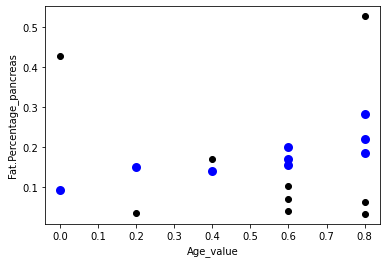

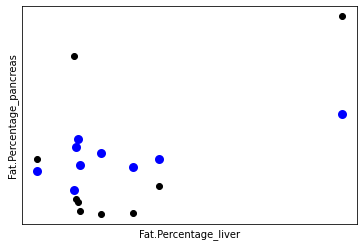

In [17]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

features = ['Age_value', 'Sex_value'] + hardy_types +  ['Fat.Percentage_liver']
target = 'Fat.Percentage_pancreas'

x_train = dataset_train.loc[:, features].values
y_train = dataset_train.loc[:,[target]].values

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:,[target]].values
y_val_pred = regr.predict(x_val)


print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Plot outputs
for i, feature_name in enumerate(features):
  if feature_name not in ['Age_value', 'Fat.Percentage_liver']:
    continue

  plt.figure()
  plt.xlabel(feature_name)
  plt.ylabel(target)
  plt.scatter(x_val[:, i], y_val,  color='black')
  plt.scatter(x_val[:, i], y_val_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [16]:
from sklearn.svm import SVR

clf = SVR(degree = 2 , kernel = 'poly')
clf.fit(x_train, y_train)
x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:,[target]].values
y_val_pred = clf.predict(x_val)


print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

Mean squared error: 0.0268
Coefficient of determination: 0.12
----------------------------------


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
from sklearn.preprocessing import PolynomialFeatures
for degree in [1,2,3,4,5,6]:
    poly = PolynomialFeatures(degree = degree)
    x_train_poly = poly.fit_transform(x_train)
    poly_reg = linear_model.LinearRegression()
    poly_reg.fit(x_train_poly, y_train)

    x_val = dataset_val.loc[:, features].values
    x_val_poly = poly.fit_transform(x_val)

    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = poly_reg.predict(x_val_poly)
    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')
    

Mean squared error: 0.0312
Coefficient of determination: -0.03
----------------------------------
Mean squared error: 0.0422
Coefficient of determination: -0.39
----------------------------------
Mean squared error: 0.0502
Coefficient of determination: -0.65
----------------------------------
Mean squared error: 0.0469
Coefficient of determination: -0.54
----------------------------------
Mean squared error: 0.1776
Coefficient of determination: -4.84
----------------------------------
Mean squared error: 2431.8049
Coefficient of determination: -80002.15
----------------------------------


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

for degree in range(1, 10):
    poly = PolynomialFeatures(degree = degree)
    x_train_poly = poly.fit_transform(x_train)
    en = ElasticNet()
    en.fit(x_train_poly, y_train)

    x_val = dataset_val.loc[:, features].values
    x_val_poly = poly.fit_transform(x_val)

    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = en.predict(x_val_poly)
    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')

In [5]:
from sklearn.preprocessing import PolynomialFeatures

for degree in [1,2,3,4,5,6]:
    poly = PolynomialFeatures(degree = degree)
    x_train_poly = poly.fit_transform(x_train)
    poly_reg = linear_model.LinearRegression()
    poly_reg.fit(x_train_poly, y_train)

    x_val = dataset_val.loc[:, features].values
    x_val_poly = poly.fit_transform(x_val)

    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = poly_reg.predict(x_val_poly)
    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')
    

Mean squared error: 0.0312
Coefficient of determination: -0.03
----------------------------------
Mean squared error: 0.0422
Coefficient of determination: -0.39
----------------------------------
Mean squared error: 0.0502
Coefficient of determination: -0.65
----------------------------------
Mean squared error: 0.0469
Coefficient of determination: -0.54
----------------------------------
Mean squared error: 0.1776
Coefficient of determination: -4.84
----------------------------------
Mean squared error: 2431.8049
Coefficient of determination: -80002.15
----------------------------------


In [6]:
from sklearn.ensemble import RandomForestRegressor

for n_estimators in [5,10,15]:
    t_regr = RandomForestRegressor(n_estimators=n_estimators)
    t_regr.fit(x_train, y_train)
    x_val = dataset_val.loc[:, features].values
    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = t_regr.predict(x_val)

    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')

Mean squared error: 0.0412
Coefficient of determination: -0.35
----------------------------------
Mean squared error: 0.0459
Coefficient of determination: -0.51
----------------------------------
Mean squared error: 0.0346
Coefficient of determination: -0.14
----------------------------------


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
for n_neighbors in [2]:
    KNN = KNeighborsRegressor(n_neighbors=n_neighbors)
    KNN.fit(x_train, y_train)
    x_val = dataset_val.loc[:, features].values
    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = KNN.predict(x_val)

    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))    
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Product

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(x_train, y_train)
x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:,[target]].values
y_val_pred = gpr.predict(x_val)

print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))    
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

Mean squared error: 0.0312
Coefficient of determination: -0.03
----------------------------------
